## NYC Taxi Anomaly Prediction

This notebook builds on NYC Yellow Taxi ride volume data from January to March 2025 by applying an LSTM-based sequence-to-sequence model for short-term forecasting.

We aim to predict hourly ride volume 1 to 6 hours into the future using only recent history, without incorporating external features like weather or calendar information. The goal is to understand how well a pure temporal model can capture the dynamics of taxi demand in NYC.

Key steps include:
- Preprocessing and resampling ride volume into hourly time series
- Normalizing and creating sliding windows of past and future ride counts
- Training an LSTM encoder-decoder model for multi-step forecasting
- Evaluating model performance with MSE and MAE
- Visualizing predicted vs. actual future ride volume over time

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import torch

import sys
import os
sys.path.append(os.path.abspath(".."))

from src.preprocess import load_data
from src.windows import create_forecasting_windows
from src.model import LSTMForecaster
from src.train import train_forecasting_model

In [5]:
# Load hourly ride volume (Jan–Mar 2025)
ride_counts = load_data(months=["01", "02", "03"], year="2025")

# Normalize
scaler = MinMaxScaler()
ride_scaled = scaler.fit_transform(ride_counts[["ride_count"]])

/Users/chaebeensong/Documents/Projects/nyc-taxi-lstm-autoencoder/src/preprocess.py:21: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ride_counts = df.resample("1H").size().to_frame(name="ride_count")


In [6]:
input_size = 24
forecast_horizon = 6

X, y = create_forecasting_windows(ride_scaled, input_size, forecast_horizon)

In [9]:
model = LSTMForecaster(
    input_dim=1, hidden_dim=64, forecast_horizon=forecast_horizon
)

trained_model, train_losses = train_forecasting_model(model, X, y, num_epochs=20, batch_size=64, learning_rate=1e-3, device="cpu")

Epoch [1/20], Loss: 0.114939
Epoch [2/20], Loss: 0.048384
Epoch [3/20], Loss: 0.046502
Epoch [4/20], Loss: 0.034297
Epoch [5/20], Loss: 0.019421
Epoch [6/20], Loss: 0.015291
Epoch [7/20], Loss: 0.013235
Epoch [8/20], Loss: 0.012103
Epoch [9/20], Loss: 0.011437
Epoch [10/20], Loss: 0.010957
Epoch [11/20], Loss: 0.010490
Epoch [12/20], Loss: 0.009967
Epoch [13/20], Loss: 0.009787
Epoch [14/20], Loss: 0.009725
Epoch [15/20], Loss: 0.009896
Epoch [16/20], Loss: 0.009233
Epoch [17/20], Loss: 0.009019
Epoch [18/20], Loss: 0.009152
Epoch [19/20], Loss: 0.009054
Epoch [20/20], Loss: 0.008141


In [ ]:
model.eval()
with torch.no_grad():
    X_tensor = torch.tensor(X, dtype=torch.float32)
    preds = model(X_tensor).numpy()  # shape: (n_samples, forecast_horizon, 1)
    true = y  

In [ ]:
# Remove last dimension --> shape: (n_samples, forecast_horizon)
preds = preds.squeeze(-1)
true = true.squeeze(-1)

# Inverse transform to original ride count scale
preds_unscaled = scaler.inverse_transform(preds)
true_unscaled = scaler.inverse_transform(true)

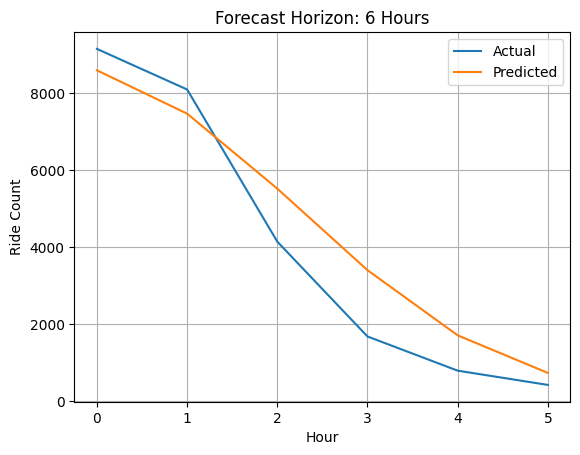

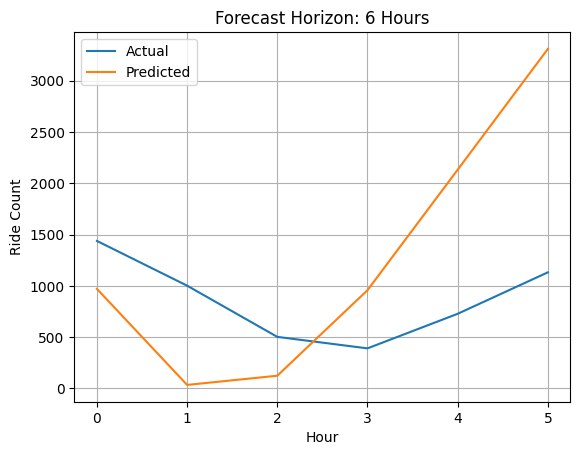

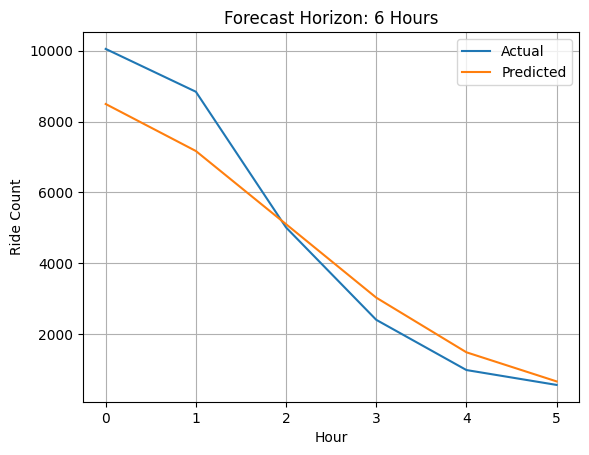

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 3 horizons chosen randomly 
for i in np.random.choice(len(preds_unscaled), 3, replace=False):
    plt.plot(true_unscaled[i], label="Actual")
    plt.plot(preds_unscaled[i], label="Predicted")
    plt.title(f"Forecast Horizon: {forecast_horizon} Hours")
    plt.xlabel("Hour")
    plt.ylabel("Ride Count")
    plt.legend()
    plt.grid(True)
    plt.show()

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(true_unscaled.flatten(), preds_unscaled.flatten())
mae = mean_absolute_error(true_unscaled.flatten(), preds_unscaled.flatten())

print(f"MSE: {mse:.2f}")
print(f"MAE: {mae:.2f}")


MSE: 1525056.52
MAE: 902.47


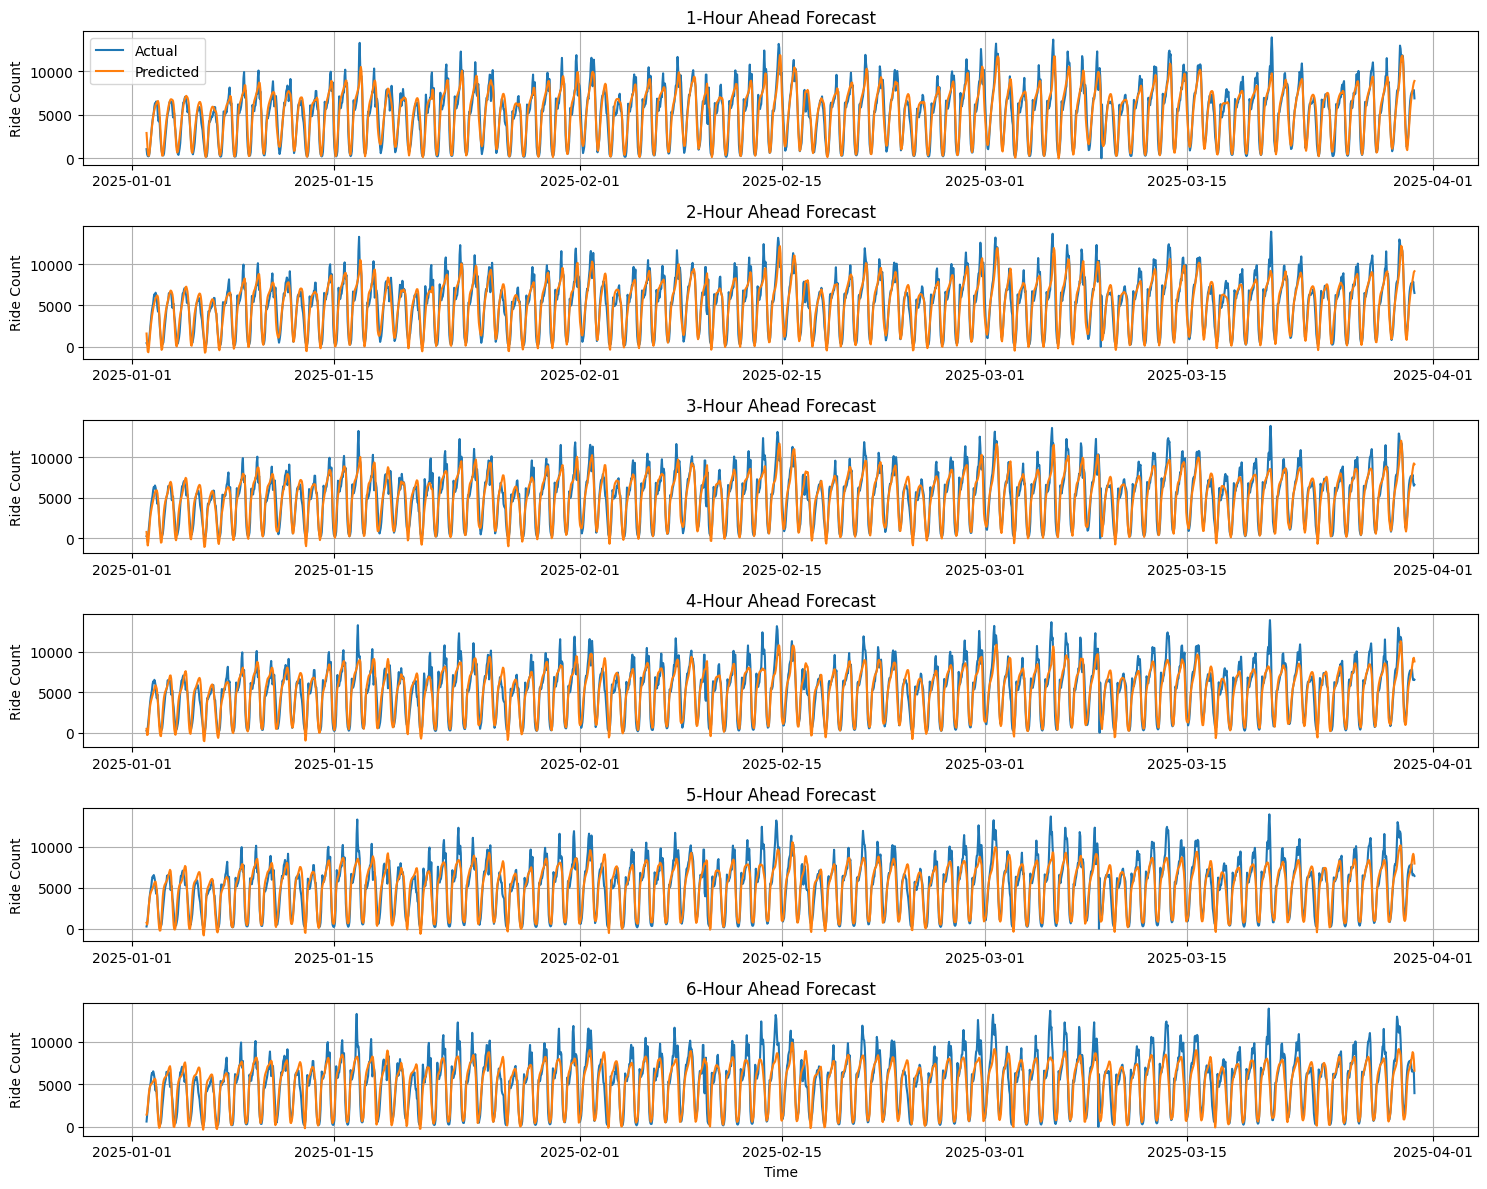

In [14]:
# Reconstruct time index for forecast outputs
start = input_size
end = start + len(preds_unscaled)
forecast_times = ride_counts.index[start:end]

# Plot for each forecast horizon
plt.figure(figsize=(15, 12))
for step in range(forecast_horizon):
    actual = true_unscaled[:, step]
    predicted = preds_unscaled[:, step]
    
    plt.subplot(forecast_horizon, 1, step + 1)
    plt.plot(forecast_times, actual, label="Actual")
    plt.plot(forecast_times, predicted, label="Predicted")
    plt.title(f"{step + 1}-Hour Ahead Forecast")
    plt.ylabel("Ride Count")
    if step == 0:
        plt.legend()
    if step == forecast_horizon - 1:
        plt.xlabel("Time")
    plt.grid(True)

plt.tight_layout()
plt.show()

The model achieved an MSE of ~1.5 million and an MAE of ~902 ride counts per hour when forecasting 6 hours ahead. While it captures broad trends in traffic volume, performance varies across different forecast horizons and is less accurate during sudden spikes or drops in demand.

Aligned visualizations show that the model performs reasonably well for short-term predictions but struggles with volatility — suggesting opportunities to improve accuracy by incorporating richer features (e.g., weekday/weekend indicators, weather, or holiday flags).

This notebook sets up a baseline for ride volume forecasting and opens the door to more advanced modeling and feature engineering.